In [1]:
import time 
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from IPython.display import SVG
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import pandas as pd
import molplotly # requires dash version 2.0 (latest = 2.1); use pip list and pip install dash==2.0
import mols2grid
from syba.syba import SybaClassifier
syba = SybaClassifier()
syba.fitDefaultScore()
import useful_rdkit_utils as uru
from tqdm import tqdm

def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.
    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None
    Chem.Kekulize(mol)
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True) 

def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi
    Parameters:
    smi (string) : smile string to be canonicalized 
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful 
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)

def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie
    Parameters: 
    selfie (string) : A selfie string - representing a molecule 
    Example: 
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']
    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie

class _FingerprintCalculator:
    ''' Calculate the fingerprint for a molecule, given the fingerprint type
    Parameters: 
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)  
    Returns:
        RDKit fingerprint object
    '''
    def get_fingerprint(self, mol: Mol, fp_type: str):
        method_name = 'get_' + fp_type
        method = getattr(self, method_name)
        if method is None:
            raise Exception(f'{fp_type} is not a supported fingerprint type.')
        return method(mol)
    def get_AP(self, mol: Mol):
        return AllChem.GetAtomPairFingerprint(mol, maxLength=10)
    def get_PHCO(self, mol: Mol):
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)
    def get_BPF(self, mol: Mol):
        return GetBPFingerprint(mol)
    def get_BTF(self, mol: Mol):
        return GetBTFingerprint(mol)
    def get_PATH(self, mol: Mol):
        return AllChem.RDKFingerprint(mol)
    def get_ECFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2)
    def get_ECFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3)
    def get_FCFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2, useFeatures=True)
    def get_FCFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3, useFeatures=True)

def get_fingerprint(mol: Mol, fp_type: str):
    ''' Fingerprint getter method. Fingerprint is returned after using object of 
        class '_FingerprintCalculator'
    Parameters: 
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)  
    Returns:
        RDKit fingerprint object
    '''
    return _FingerprintCalculator().get_fingerprint(mol=mol, fp_type=fp_type)

def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on selfie is performed)  
    Mutations are done until a valid molecule is obtained 
    Rules of mutation: With a 33.3% propbabily, either: 
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character
    Parameters:
    selfie            (string)  : SELFIE string to be mutated 
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"
    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)
    
    while not valid:
        fail_counter += 1
                
        alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters 

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]
        
        # Insert a character in a Random Location
        if random_choice == 1: 
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]
            
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character 
        elif random_choice == 2:                         
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]
                
        # Delete a random character
        elif random_choice == 3: 
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]
                
        else: 
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)
        
        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="":
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()
    
    return (selfie_mutated, smiles_canon)

def get_mutated_SELFIES(selfies_ls, num_mutations): 
    ''' Mutate all the SELFIES in 'selfies_ls' 'num_mutations' number of times. 
    
    Parameters:
    selfies_ls   (list)  : A list of SELFIES 
    num_mutations (int)  : number of mutations to perform on each SELFIES within 'selfies_ls'
    
    Returns:
    selfies_ls   (list)  : A list of mutated SELFIES
    
    '''
    for _ in range(num_mutations): 
        selfie_ls_mut_ls = []
        for str_ in selfies_ls: 
            
            str_chars = get_selfie_chars(str_)
            max_molecules_len = len(str_chars) + num_mutations
            
            selfie_mutated, _ = mutate_selfie(str_, max_molecules_len)
            selfie_ls_mut_ls.append(selfie_mutated)
        
        selfies_ls = selfie_ls_mut_ls.copy()
    return selfies_ls


def get_fp_scores(smiles_back, target_smi, fp_type): 
    '''Calculate the Tanimoto fingerprint (using fp_type fingerint) similarity between a list 
       of SMILES and a known target structure (target_smi). 
       
    Parameters:
    smiles_back   (list) : A list of valid SMILES strings 
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    fp_type (string)     : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6) 
    
    Returns: 
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)

    fp_target = get_fingerprint(target, fp_type)

    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_fingerprint(mol, fp_type)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores

def view_difference(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    for atom in mol1.GetAtoms():
        if atom.GetIdx() not in match1:
            target_atm1.append(atom.GetIdx())
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm2 = []
    for atom in mol2.GetAtoms():
        if atom.GetIdx() not in match2:
            target_atm2.append(atom.GetIdx())
    return Draw.MolsToGridImage([mol1, mol2],highlightAtomLists=[target_atm1, target_atm2],subImgSize=(400,400),useSVG=True)

## Generate analogs without structural restrictions

Mutate the entire molecule

*Sections 1 and 2 share a number of variables so should be run independently*

Celecoxib example = CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F

Example from mmpa = O=S(=O)(c3ccc(n1nc(cc1c2ccc(cc2)C)C(F)(F)F)cc3)N

Elexacaftor = C[C@@H]1CN(C2=NC(=CC=C2C(=O)NS(=O)(=O)C2=CN(C)N=C2C)N2C=CC(OCC(C)(C)C(F)(F)F)=N2)C(C)(C)C1

Tezacaftor = CC(C)(CO)C1=CC2=CC(NC(=O)C3(CC3)C3=CC=C4OC(F)(F)OC4=C3)=C(F)C=C2N1CC@@HCO

Ivacaftor = CC(C)(C)C1=CC(=C(O)C=C1NC(=O)C1=CNC2=CC=CC=C2C1=O)C(C)(C)C

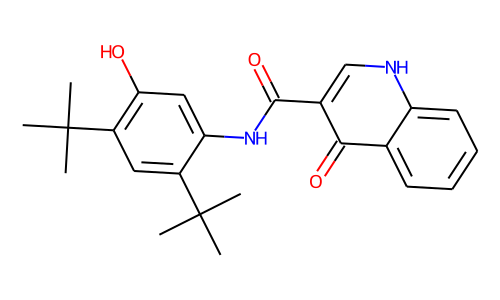

In [2]:
smi = 'CC(C)(C)C1=CC(=C(O)C=C1NC(=O)C1=CNC2=CC=CC=C2C1=O)C(C)(C)C'   

mol1 = Chem.MolFromSmiles(smi)
d2d = rdMolDraw2D.MolDraw2DSVG(500,300)
rdMolDraw2D.PrepareAndDrawMolecule(d2d, mol1)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Run the analysis (change num_random_samples for number of mutations)

In [3]:
fp_type = 'ECFP4'

total_time = time.time()
num_random_samples = 1000    # 1000 standard, use 50000 for a more exhaustive search 
num_mutation_ls    = [1, 2, 3, 4, 5]

mol = Chem.MolFromSmiles(smi)
if mol == None: 
    raise Exception('Invalid starting structure encountered')

start_time = time.time()
randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]

# Convert all the molecules to SELFIES
selfies_ls = [encoder(x) for x in randomized_smile_orderings]
print('Randomized molecules (in SELFIES) time: ', "{:.2f}".format(time.time()-start_time))

all_smiles_collect = []
all_smiles_collect_broken = []

start_time = time.time()
for num_mutations in tqdm(num_mutation_ls): 
    # Mutate the SELFIES: 
    selfies_mut = get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutations)
    # Convert back to SMILES: 
    smiles_back = [decoder(x) for x in selfies_mut]
    all_smiles_collect = all_smiles_collect + smiles_back
    all_smiles_collect_broken.append(smiles_back)
print('Mutation obtainment time (back to smiles): ', "{:.2f}".format(time.time()-start_time))

# Work on:  all_smiles_collect
start_time = time.time()
canon_smi_ls = []
for item in all_smiles_collect: 
    mol, smi_canon, did_convert = sanitize_smiles(item)
    if mol == None or smi_canon == '' or did_convert == False: 
        raise Exception('Invalid smile string found')
    canon_smi_ls.append(smi_canon)
canon_smi_ls        = list(set(canon_smi_ls))
print('Unique mutated structure obtainment time: ', "{:.2f}".format(time.time()-start_time))

start_time = time.time()
canon_smi_ls_scores = get_fp_scores(canon_smi_ls, target_smi=smi, fp_type=fp_type)
print('Fingerprint calculation time: ', "{:.2f}".format(time.time()-start_time))
print('Total time: ', "{:.2f}".format(time.time()-total_time))

# Molecules with fingerprint similarity > 0.8
indices_thresh_8 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.8]
mols_8 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_8]

# Molecules with fingerprint similarity > 0.6
indices_thresh_6 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.6 and x < 0.8]
mols_6 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_6]

# Molecules with fingerprint similarity > 0.4
indices_thresh_4 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.4 and x < 0.6]
mols_4 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_4]

print(len(canon_smi_ls),'generated molecules')
print(len(mols_8),'molecules with fingerprint similarity > 0.8')
print(len(mols_6),'molecules with fingerprint similarity > 0.6')
print(len(mols_4),'molecules with fingerprint similarity > 0.4')

Randomized molecules (in SELFIES) time:  0.37
Mutation obtainment time (back to smiles):  8.38
Unique mutated structure obtainment time:  0.71
Fingerprint calculation time:  0.62
Total time:  10.09
48 molecules with fingerprint similarity > 0.8
210 molecules with fingerprint similarity > 0.6
856 molecules with fingerprint similarity > 0.4


**Visualize unfiltered results**

In [4]:
unfiltered_res = mols_8

unfiltered_res_df = pd.DataFrame({'rdkit_objects': unfiltered_res})
unfiltered_res_df['smiles'] = unfiltered_res_df['rdkit_objects'].map(Chem.MolToSmiles)

grid = mols2grid.MolGrid(unfiltered_res_df, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["smiles","img"], n_cols=5)

**Filter structures using structural alerts and similarity scores**

In [5]:
reos = uru.REOS()
rule_path = reos.get_rule_file_location()
print('Rules file:',rule_path)
print('Available sets of rules:',reos.get_available_rule_sets())

#reos.set_active_rule_sets(['Glaxo','BMS'])
reos.set_active_rule_sets(['Glaxo','Dundee','BMS','PAINS','SureChEMBL','MLSMR','Inpharmatica','LINT'])

print('Currently active rule set(s):',reos.get_active_rule_sets())
print('Number of currently active rules:',reos.active_rule_df.shape[0])

Rules file: /Users/cian/.data/useful_rdkit_utils/data/alert_collection.csv
Available sets of rules: ['Glaxo' 'Dundee' 'BMS' 'PAINS' 'SureChEMBL' 'MLSMR' 'Inpharmatica' 'LINT']
Currently active rule set(s): ['Glaxo' 'Dundee' 'BMS' 'PAINS' 'SureChEMBL' 'MLSMR' 'Inpharmatica' 'LINT']
Number of currently active rules: 1251


In [11]:
df_rules = pd.DataFrame({'smiles': canon_smi_ls})
df_rules.insert(0, 'ID', range(1, 1+len(df_rules)))

x = df_rules.smiles.apply(reos.process_smiles).to_list()
y, z = zip(*x)
df_rules['rule_set_name'] = y
df_rules['problem substructure'] = z
print('number of compounds before filtering =',len(df_rules))

df_rules_ok = df_rules.loc[df_rules['rule_set_name'] == 'ok']
print('number of compounds after filtering =',len(df_rules_ok))
df_rules_ok

number of compounds before filtering = 4725
number of compounds after filtering = 318


,ID,smiles,rule_set_name,problem substructure
31,32,CC(C)(C)C1=C(O)C=CC(C)([N+])C(CNC(=O)c2c[nH]c3...,ok,ok
66,67,CC(C)(C)C1=CC(C(C)(C)C)=C(O)CN1C(=O)c1c[nH]c2c...,ok,ok
72,73,C,ok,ok
85,86,CCC(C)(C)C1(C)CC=C(O)C=C(NC(=O)c2c[nH]c3ccccc3...,ok,ok
97,98,C1=CCC=C1,ok,ok
...,...,...,...,...
4671,4672,Clc1ccccc1,ok,ok
4685,4686,CC(C)(C)C1=CC(C(C)(C)C)C(O)=CN1C(=O)c1c[nH]c2c...,ok,ok
4697,4698,CC1(C)CC(O)(C(C)(C)C)C=C1NC(=O)c1c[nH]c2ccccc2...,ok,ok
4699,4700,O=c1c([O-])c[nH]c2ccccc12,ok,ok


In [7]:
#df_rules_ok = df_rules_ok.head(100)

grid = mols2grid.MolGrid(df_rules_ok, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["ID","img"], n_cols=5)

Calculate similarity scores

In [13]:
smi_list = list(df_rules_ok['smiles'])
smi_similarity_scores = get_fp_scores(smi_list, target_smi=smi, fp_type='ECFP4')
smi_similarity_scores = [round(num, 2) for num in smi_similarity_scores]
df_rules_ok.insert(4,'fp_similarity',smi_similarity_scores)
df_rules_ok

,ID,smiles,rule_set_name,problem substructure,fp_similarity
31,32,CC(C)(C)C1=C(O)C=CC(C)([N+])C(CNC(=O)c2c[nH]c3...,ok,ok,0.48
66,67,CC(C)(C)C1=CC(C(C)(C)C)=C(O)CN1C(=O)c1c[nH]c2c...,ok,ok,0.58
72,73,C,ok,ok,0.00
85,86,CCC(C)(C)C1(C)CC=C(O)C=C(NC(=O)c2c[nH]c3ccccc3...,ok,ok,0.50
97,98,C1=CCC=C1,ok,ok,0.04
...,...,...,...,...,...
4671,4672,Clc1ccccc1,ok,ok,0.14
4685,4686,CC(C)(C)C1=CC(C(C)(C)C)C(O)=CN1C(=O)c1c[nH]c2c...,ok,ok,0.56
4697,4698,CC1(C)CC(O)(C(C)(C)C)C=C1NC(=O)c1c[nH]c2ccccc2...,ok,ok,0.53
4699,4700,O=c1c([O-])c[nH]c2ccccc12,ok,ok,0.33


Filter using the similarity scores, adjust the cutoff value and check structures

In [18]:
cutoff = 0.3

df_similarity_filter = df_rules_ok.loc[df_rules_ok['fp_similarity'] >= cutoff]
df_similarity_filter

,ID,smiles,rule_set_name,problem substructure,fp_similarity
31,32,CC(C)(C)C1=C(O)C=CC(C)([N+])C(CNC(=O)c2c[nH]c3...,ok,ok,0.48
66,67,CC(C)(C)C1=CC(C(C)(C)C)=C(O)CN1C(=O)c1c[nH]c2c...,ok,ok,0.58
85,86,CCC(C)(C)C1(C)CC=C(O)C=C(NC(=O)c2c[nH]c3ccccc3...,ok,ok,0.50
154,155,CC1CCC=CC(NC(=O)C2=CNc3ccccc3C2[N-])=CC(O)=C1C...,ok,ok,0.31
155,156,CC(C)c1cc(CC(C)(C)C)c(O)cc1C(N)c1c[nH]c2ccccc2...,ok,ok,0.45
...,...,...,...,...,...
4573,4574,CC(C)C(C)(C)C(C)c1ccc(NC(=O)c2c[nH]c3ccccc3c2=...,ok,ok,0.55
4576,4577,CCC(C)CCC1=C(O)C=C(NC(=O)c2c[nH]c3ccccc3c2=O)C...,ok,ok,0.43
4685,4686,CC(C)(C)C1=CC(C(C)(C)C)C(O)=CN1C(=O)c1c[nH]c2c...,ok,ok,0.56
4697,4698,CC1(C)CC(O)(C(C)(C)C)C=C1NC(=O)c1c[nH]c2ccccc2...,ok,ok,0.53


In [19]:
grid = mols2grid.MolGrid(df_similarity_filter, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["ID","fp_similarity","img"], n_cols=5)

Compare the original structure to a particular analog

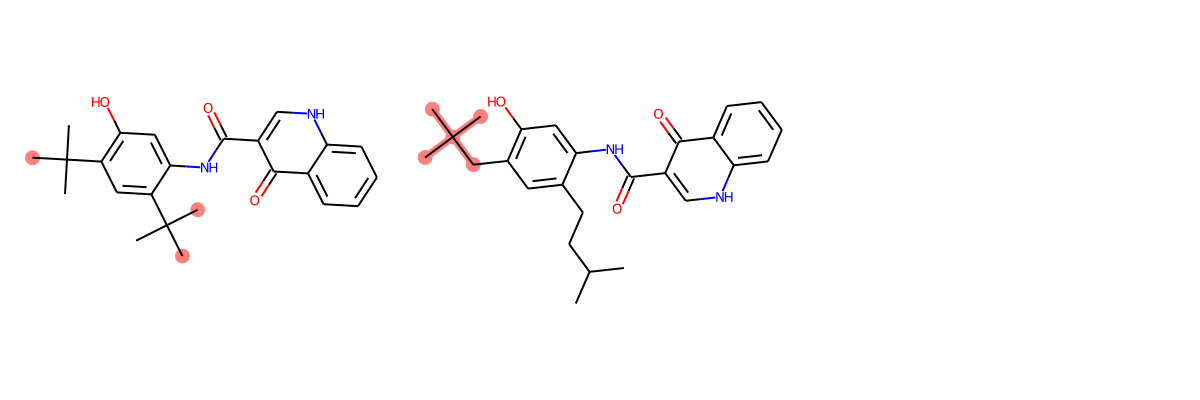

In [20]:
ID = 204    # the ID for the molecule of interest

df = df_rules_ok.loc[df_rules_ok['ID'] == ID]
df_smi = df['smiles']
np_smi = df_smi.to_numpy()
mol2 = Chem.MolFromSmiles(np_smi[0])

view_difference(mol1,mol2)

In [ ]:
df_similarity_filter.to_csv('SELFIES_analogs.csv', index = True)

## Generate analogs with structural restrictions

Analogs are generated by mutating the molecule except for a defined substructure

*Sections 1 and 2 share a number of variables so should be run independently*

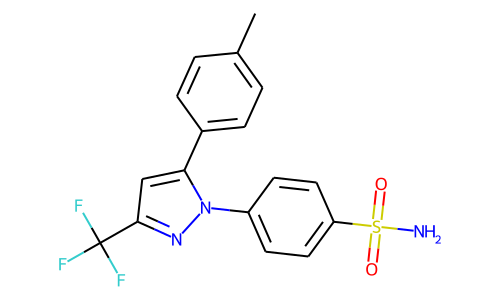

In [32]:
#smi = 'CC(C)(C)C1=CC(=C(O)C=C1NC(=O)C1=CNC2=CC=CC=C2C1=O)C(C)(C)C'    # example 1
smi = 'O=S(=O)(c3ccc(n1nc(cc1c2ccc(cc2)C)C(F)(F)F)cc3)N'             # example 2

mol1 = Chem.MolFromSmiles(smi)
d2d = rdMolDraw2D.MolDraw2DSVG(500,300)
rdMolDraw2D.PrepareAndDrawMolecule(d2d, mol1)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

input_frag is the portion of the molecule that will not be mutated

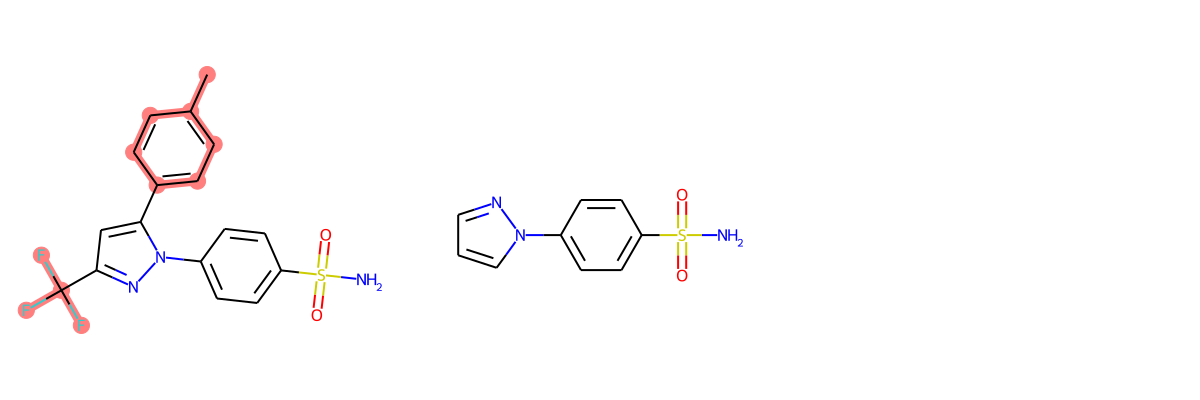

In [33]:
#input_frag = "OC1=CC=C(C(C)(C)C)C=C1C(C)(C)C"  # example 1 fragment  (not working)
#input_frag = "CS(N)(=O)=O"                      # example 2 fragment 1
input_frag = "NS(=O)(=O)c1ccc(-n2cccn2)cc1"    # example 2 fragment 2

mol2 = Chem.MolFromSmiles(input_frag)
view_difference(mol1,mol2)

In [34]:
def substructure_preserver(mol):
    """
    Check for substructure violates
    Return True: contains a substructure violation
    Return False: No substructure violation
    """        
    
    if mol.HasSubstructMatch(rdkit.Chem.MolFromSmarts(input_frag)) == True:
        return True # The has substructure
    else: 
        return False # Molecule does not have substructure

def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on selfie is performed)
    
    Mutations are done until a valid molecule is obtained 
    Rules of mutation: With a 33.3% propbabily, either: 
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character
    
    Parameters:
    selfie            (string)  : SELFIE string to be mutated 
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"
    
    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)
    
    while not valid:
        fail_counter += 1
                
        alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters 

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]
        
        # Insert a character in a Random Location
        if random_choice == 1: 
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character 
        elif random_choice == 2:                         
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]
                
        # Delete a random character
        elif random_choice == 3: 
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]
        else: 
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)
        
        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="" or substructure_preserver(mol)==False:
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()
    
    return (selfie_mutated, smiles_canon)

Run the analysis (change num_random_samples for number of mutations)

In [35]:
fp_type = 'ECFP4'

total_time = time.time()
num_random_samples = 1000     # use 50000 for a more exhaustive search
num_mutation_ls    = [1, 2, 3, 4, 5]

mol = Chem.MolFromSmiles(smi)
if mol == None: 
    raise Exception('Invalid starting structure encountered')

start_time = time.time()
randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]

# Convert all the molecules to SELFIES
selfies_ls = [encoder(x) for x in randomized_smile_orderings]
print('Randomized molecules (in SELFIES) time: ', "{:.2f}".format(time.time()-start_time))

all_smiles_collect = []
all_smiles_collect_broken = []

start_time = time.time()
for num_mutations in tqdm(num_mutation_ls): 
    # Mutate the SELFIES: 
    selfies_mut = get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutations)
    # Convert back to SMILES: 
    smiles_back = [decoder(x) for x in selfies_mut]
    all_smiles_collect = all_smiles_collect + smiles_back
    all_smiles_collect_broken.append(smiles_back)
print('Mutation obtainment time (back to smiles): ', "{:.2f}".format(time.time()-start_time))

# Work on:  all_smiles_collect
start_time = time.time()
canon_smi_ls = []
for item in all_smiles_collect: 
    mol, smi_canon, did_convert = sanitize_smiles(item)
    if mol == None or smi_canon == '' or did_convert == False: 
        raise Exception('Invalid smile string found')
    canon_smi_ls.append(smi_canon)
canon_smi_ls        = list(set(canon_smi_ls))
print('Unique mutated structure obtainment time: ', "{:.2f}".format(time.time()-start_time))

start_time = time.time()
canon_smi_ls_scores = get_fp_scores(canon_smi_ls, target_smi=smi, fp_type=fp_type)
print('Fingerprint calculation time: ', "{:.2f}".format(time.time()-start_time))
print('Total time: ', "{:.2f}".format(time.time()-total_time))

# Molecules with fingerprint similarity > 0.8
indices_thresh_8 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.8]
substruct_mols_8 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_8]

# Molecules with fingerprint similarity > 0.6
indices_thresh_6 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.6 and x < 0.8]
substruct_mols_6 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_6]

# Molecules with fingerprint similarity > 0.4
indices_thresh_4 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.4 and x < 0.6]
substruct_mols_4 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_4]

print(len(canon_smi_ls),'generated molecules')
print(len(substruct_mols_8),'molecules with fingerprint similarity > 0.8')
print(len(substruct_mols_6),'molecules with fingerprint similarity > 0.6')
print(len(substruct_mols_4),'molecules with fingerprint similarity > 0.4')

  0%|          | 0/5 [00:00<?, ?it/s]

Randomized molecules (in SELFIES) time:  0.35


100%|██████████| 5/5 [00:34<00:00,  7.00s/it]


Mutation obtainment time (back to smiles):  34.98
Unique mutated structure obtainment time:  0.75
Fingerprint calculation time:  0.53
Total time:  36.61
3747 generated molecules
92 molecules with fingerprint similarity > 0.8
673 molecules with fingerprint similarity > 0.6
2178 molecules with fingerprint similarity > 0.4


**Visualize unfiltered results (typically lots of bad molecules, filter below)**

In [ ]:
substruct_res = substruct_mols_6

substruct_res_df = pd.DataFrame({'rdkit_objects': substruct_res})
substruct_res_df['smiles'] = substruct_res_df['rdkit_objects'].map(Chem.MolToSmiles)

grid = mols2grid.MolGrid(substruct_res_df, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["smiles","img"], n_cols=5)

**Filter structures using structural alerts and similarity scores**

In [36]:
reos = uru.REOS()
rule_path = reos.get_rule_file_location()
print('Rules file:',rule_path)
print('Available sets of rules:',reos.get_available_rule_sets())

#reos.set_active_rule_sets(['Glaxo','BMS'])
reos.set_active_rule_sets(['Glaxo','Dundee','BMS','PAINS','SureChEMBL','MLSMR','Inpharmatica','LINT'])

print('Currently active rule set(s):',reos.get_active_rule_sets())
print('Number of currently active rules:',reos.active_rule_df.shape[0])

Rules file: /Users/cian/.data/useful_rdkit_utils/data/alert_collection.csv
Available sets of rules: ['Glaxo' 'Dundee' 'BMS' 'PAINS' 'SureChEMBL' 'MLSMR' 'Inpharmatica' 'LINT']
Currently active rule set(s): ['Glaxo' 'Dundee' 'BMS' 'PAINS' 'SureChEMBL' 'MLSMR' 'Inpharmatica' 'LINT']
Number of currently active rules: 1251


In [37]:
df_rules = pd.DataFrame({'smiles': canon_smi_ls})
df_rules.insert(0, 'ID', range(1, 1+len(df_rules)))

x = df_rules.smiles.apply(reos.process_smiles).to_list()
y, z = zip(*x)
df_rules['rule_set_name'] = y
df_rules['problem substructure'] = z
print('number of compounds before filtering =',len(df_rules))

df_rules_ok = df_rules.loc[df_rules['rule_set_name'] == 'ok']
print('number of compounds after filtering =',len(df_rules_ok))
df_rules_ok

number of compounds before filtering = 3747
number of compounds after filtering = 347


,ID,smiles,rule_set_name,problem substructure
3,4,NS(=O)(=O)c1ccc(-n2nc(C(F)(F)F)cc2C2=NC=CC2)cc1,ok,ok
17,18,NS(=O)(=O)c1ccc2cc1C1CCCc3c(C(F)(F)F)nn-2c3C1,ok,ok
19,20,Cc1ccc([N-]c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)...,ok,ok
28,29,CC1=CC(c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)...,ok,ok
40,41,Cc1ccc(-c2cc(CCF)nn2-c2ccc(S(N)(=O)=O)cc2CF)cn1,ok,ok
...,...,...,...,...
3685,3686,NS(=O)(=O)c1ccc(-n2nc(CF)c3ccc(CCF)cc32)cc1,ok,ok
3697,3698,CC1=CCC(c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,ok,ok
3709,3710,Cc1ccc(-c2c(CF)cnn2-c2ccc(S(N)(=O)=O)cc2)cc1,ok,ok
3721,3722,NS(=O)(=O)c1ccc2c(c1)CC=Cc1cc(C(F)(F)F)nn1-2,ok,ok


In [38]:
#df_rules_ok = df_rules_ok.head(100)

grid = mols2grid.MolGrid(df_rules_ok, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["ID","img"], n_cols=5)

Calculate similarity scores

In [39]:
smi_list = list(df_rules_ok['smiles'])
smi_similarity_scores = get_fp_scores(smi_list, target_smi=smi, fp_type='ECFP4')
smi_similarity_scores = [round(num, 2) for num in smi_similarity_scores]
df_rules_ok.insert(4,'fp_similarity',smi_similarity_scores)
df_rules_ok

,ID,smiles,rule_set_name,problem substructure,fp_similarity
3,4,NS(=O)(=O)c1ccc(-n2nc(C(F)(F)F)cc2C2=NC=CC2)cc1,ok,ok,0.63
17,18,NS(=O)(=O)c1ccc2cc1C1CCCc3c(C(F)(F)F)nn-2c3C1,ok,ok,0.33
19,20,Cc1ccc([N-]c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)...,ok,ok,0.77
28,29,CC1=CC(c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)...,ok,ok,0.67
40,41,Cc1ccc(-c2cc(CCF)nn2-c2ccc(S(N)(=O)=O)cc2CF)cn1,ok,ok,0.39
...,...,...,...,...,...
3685,3686,NS(=O)(=O)c1ccc(-n2nc(CF)c3ccc(CCF)cc32)cc1,ok,ok,0.45
3697,3698,CC1=CCC(c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,ok,ok,0.67
3709,3710,Cc1ccc(-c2c(CF)cnn2-c2ccc(S(N)(=O)=O)cc2)cc1,ok,ok,0.62
3721,3722,NS(=O)(=O)c1ccc2c(c1)CC=Cc1cc(C(F)(F)F)nn1-2,ok,ok,0.46


Filter using the similarity scores, adjust the cutoff value and check structures

In [43]:
cutoff = 0.3

df_similarity_filter = df_rules_ok.loc[df_rules_ok['fp_similarity'] >= cutoff]
df_similarity_filter

,ID,smiles,rule_set_name,problem substructure,fp_similarity
3,4,NS(=O)(=O)c1ccc(-n2nc(C(F)(F)F)cc2C2=NC=CC2)cc1,ok,ok,0.63
17,18,NS(=O)(=O)c1ccc2cc1C1CCCc3c(C(F)(F)F)nn-2c3C1,ok,ok,0.33
19,20,Cc1ccc([N-]c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)...,ok,ok,0.77
28,29,CC1=CC(c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)...,ok,ok,0.67
40,41,Cc1ccc(-c2cc(CCF)nn2-c2ccc(S(N)(=O)=O)cc2CF)cn1,ok,ok,0.39
...,...,...,...,...,...
3669,3670,CC1=CCc2c(c(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)...,ok,ok,0.53
3685,3686,NS(=O)(=O)c1ccc(-n2nc(CF)c3ccc(CCF)cc32)cc1,ok,ok,0.45
3697,3698,CC1=CCC(c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,ok,ok,0.67
3709,3710,Cc1ccc(-c2c(CF)cnn2-c2ccc(S(N)(=O)=O)cc2)cc1,ok,ok,0.62


In [44]:
grid = mols2grid.MolGrid(df_similarity_filter, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["ID","fp_similarity","img"], n_cols=5)

Compare the original structure to a particular analog

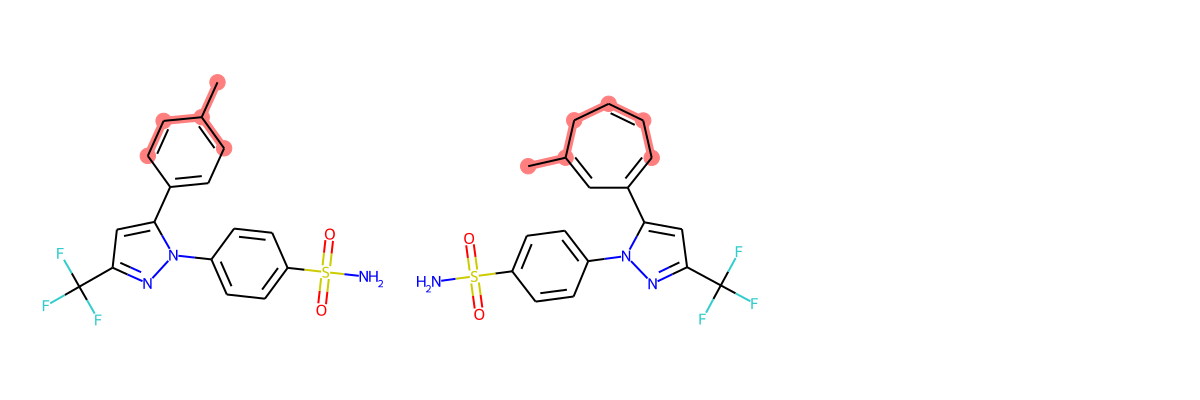

In [45]:
ID = 29    # the ID for the molecule of interest

df = df_rules_ok.loc[df_rules_ok['ID'] == ID]
df_smi = df['smiles']
np_smi = df_smi.to_numpy()
mol2 = Chem.MolFromSmiles(np_smi[0])

view_difference(mol1,mol2)

In [ ]:
df_similarity_filter.to_csv('SELFIES_analogs.csv', index = True)